In [24]:
import sys
assert sys.version_info >= (3, 5)
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import warnings
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import utils as ut

In [25]:
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification, make_blobs, load_breast_cancer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

# modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

DISPLAY_PRECISION = 4
pd.set_option("display.precision", DISPLAY_PRECISION)

In [26]:
DATA_PATH = "../data/union/End"
def load_data_prep(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "dataset_final.csv")
    return pd.read_csv(csv_path)

In [27]:
df = load_data_prep()
df1 = df[ut.sel_colum()]

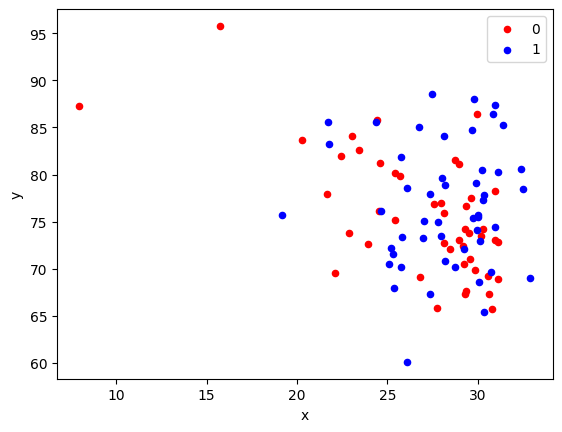

In [28]:
# scatter plot, colores por etiquetas
df2 = pd.DataFrame(dict(x=df1.ccbd_diameter, y=df1.sl2l_mean_length, label=df1.label))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df2.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

In [29]:
df3 = df1
df3.label.value_counts()

label
1    50
0    46
Name: count, dtype: int64

In [30]:
df3.label.value_counts()/df1.label.count()*100

label
1    52.0833
0    47.9167
Name: count, dtype: float64

In [31]:
# Partición en train y test
y = df1.loc[:, df1.columns == 'label']
X = df1.loc[:, df1.columns != 'label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [32]:
train = X_train
train['label'] = y_train.label.to_list()

control = train[train.label == 1]
print(len(control))
estudio = train[train.label == 0]
print(len(estudio))
control_sub = control.sample(n=len(estudio), random_state=99)
len(control_sub)
train_sub = pd.concat([estudio, control_sub])
len(train_sub)
y_train = train_sub.loc[:, train_sub.columns == 'label']
X_train = train_sub.loc[:, train_sub.columns != 'label']
X_train.shape, y_train.shape

38
38


((76, 20), (76, 1))

#### Entrenar un modelo y predecir valores anómalos

Lo primero que vamos a hacer es analizar los parámetros más relevantes.

In [33]:
!pip install -q xgboost

In [34]:
%matplotlib inline

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from IPython import display
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [35]:
seed = 1234

In [36]:
std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente

In [37]:
X_out = df1.loc[:, df1.columns == 'label']


In [38]:
# Ajustamos el estandarizador
std_scale.fit(X_out)

# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_out_scaled = std_scale.transform(X_out)

In [39]:
iso_forest = IsolationForest(max_samples = "auto", contamination = "auto", random_state = seed)

In [40]:
iso_forest.fit(X_out_scaled)

IsolationForest(random_state=1234)

In [41]:
outlier_pred = iso_forest.predict(X_out_scaled)
outlier_pred = [False if x == 1 else True for x in outlier_pred]

### Seleccion de features

In [42]:
#!pip install -U scikit-learn
# !pip install -U sklearn
#!pip install scipy -U 
# !pip uninstall sklearn
# !pip uninstall scikit-learn


In [43]:
X = df1.drop('label', axis=1) # features
y = df1['label'] # target

In [44]:
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score

El AUC promedio es:
0.8489


Text(0, 0.5, 'Folds')

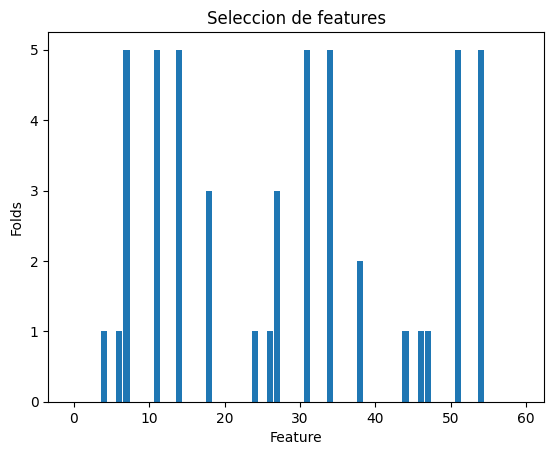

In [46]:


# Definamos la matriz X
X = np.concatenate((X, X**2,X**3), axis=1) # agrego features elevados a potencias 

Kbest = 10 # los mejores K que voy a retener

skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y) # arma los folds a partir de los datos

auc_values_fs =  []  # aca es donde van a ir a parar los indices de los features seleccionados en cada fold
selected_features= np.array([]).reshape(0,X.shape[1]) # aca es donde van a ir a parar los AUCs de cada fold. El reshape es para poder concatenar luego.


for train_index, test_index in skf.split(X, y): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y[train_index], y[test_index]     # idem con los targets

    scaler = StandardScaler() # escaleo por separado ambos sets
    scaler.fit(X_train) 
    X_train = scaler.transform(X_train)

    scaler = StandardScaler() # escaleo por separado ambos sets
    scaler.fit(X_test) 
    X_test = scaler.transform(X_test)

    selector = SelectKBest(k=Kbest) # por defecto, usa el F score de ANOVA y los Kbest features
    selector.fit(X_train, y_train) # encuentro los F scores 
    X_train_fs = selector.transform(X_train) # me quedo con los features mejor rankeados en el set de entrenamiento
    X_test_fs = selector.transform(X_test) # me quedo con los features mejor rankeados en el set de evaluacion
    features = np.array(selector.get_support()).reshape((1,-1)) # esto me pone True si la variable correspondiente fue seleccionada y False sino

    selected_features =  np.concatenate((selected_features,features),axis=0)

    regLog = LogisticRegression( max_iter=20000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog.fit(X_train_fs, y_train) # Ajustamos el modelo con los datos de entrenamiento


    probas_test = regLog.predict_proba(X_test_fs)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación
    auc_values_fs.append(auc_test)

print('El AUC promedio es:')
print(format(round(np.mean(auc_values_fs),4)))


import matplotlib.pyplot as plt

plt.bar(np.arange(0,X.shape[1]),np.sum(selected_features,axis=0))
plt.title('Seleccion de features')
plt.xlabel('Feature')
plt.ylabel('Folds')

In [72]:
selected_features

Index(['ccbd_diameter', 'sl2l_mean_length', 'ecpl_mean_length',
       'ccbd_number_of_tracts'],
      dtype='object')

In [47]:
X = StandardScaler().fit_transform(X) # lo escaleo

In [48]:
X = df1.drop('label', axis=1) # features
y = df1['label'] # target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((76, 20), (20, 20))

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

Step Fordward Selection (SFS) es un método de selección de características que se basa en la idea de que las mejores subconjuntos de características contienen las características que son fuertemente correlacionadas con la variable de salida, y no están correlacionadas entre sí. El algoritmo SFS comienza con un conjunto vacío de características y en cada paso, se agrega la característica más útil al conjunto actual. El proceso se repite hasta que se alcanza el número deseado de características.


In [88]:
sfs = SFS(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs = -1),
          k_features = 6,
          forward= True,
          floating = False,
          verbose= 2,
          scoring= 'accuracy',
          cv = 5,
          n_jobs= -1
         ).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    2.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.0s finished

[2023-07-17 12:32:40] Features: 1/6 -- score: 0.71[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    1.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.6s finished

[2023-07-17 12:32:43] Features: 2/6 -- score: 0.7508333333333332[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    1.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.6s finished

[2023-07-17 12:32:46] Features: 3/6 -- score: 0.7775000000000001[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    2.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed: 

In [51]:
# df1.iloc[:,sfs.k_feature_idx_[0]].name, df1.iloc[:,sfs.k_feature_idx_[1]].name, df1.iloc[:,sfs.k_feature_idx_[2]].name

In [89]:
sfs.k_feature_names_     # nombres de los features seleccionados

('ccbd_diameter',
 'sl2l_mean_length',
 'sl2l_diameter',
 'ccbd_mean_length',
 'sl2l_volume',
 'tral_volume')

In [79]:
sfs.k_feature_idx_

(0, 1, 9, 14, 16, 18)

In [80]:
sfs.k_score_

0.7891666666666668

In [81]:
df1.from_dict(sfs.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(14,)","[0.75, 0.8, 0.8, 0.6666666666666666, 0.5333333...",0.71,"(ccbd_mean_length,)",0.1297,0.1009,0.0504
2,"(1, 14)","[0.6875, 0.6666666666666666, 0.866666666666666...",0.7508,"(sl2l_mean_length, ccbd_mean_length)",0.0949,0.0738,0.0369
3,"(1, 14, 18)","[0.6875, 0.8, 0.8666666666666667, 0.7333333333...",0.7775,"(sl2l_mean_length, ccbd_mean_length, tral_volume)",0.0793,0.0617,0.0308
4,"(1, 9, 14, 18)","[0.75, 0.8666666666666667, 0.8, 0.733333333333...",0.7767,"(sl2l_mean_length, sl2l_diameter, ccbd_mean_le...",0.0658,0.0512,0.0256
5,"(1, 9, 14, 16, 18)","[0.875, 0.8, 0.7333333333333333, 0.6, 0.733333...",0.7483,"(sl2l_mean_length, sl2l_diameter, ccbd_mean_le...",0.1166,0.0907,0.0454
6,"(0, 1, 9, 14, 16, 18)","[0.8125, 0.8666666666666667, 0.8, 0.6666666666...",0.7892,"(ccbd_diameter, sl2l_mean_length, sl2l_diamete...",0.0849,0.066,0.033


### Feature Combination
Gaining the best combination of the features based on their avg-score

In [82]:
sfs = SFS(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs = -1),
         k_features = (1, 6),
          forward= True,
          floating = False,
          verbose= 2,
          scoring= 'accuracy',
          cv = 5,
          n_jobs= -1
         ).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    2.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.3s finished

[2023-07-17 12:29:29] Features: 1/6 -- score: 0.71[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    2.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.9s finished

[2023-07-17 12:29:32] Features: 2/6 -- score: 0.7508333333333332[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    2.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.7s finished

[2023-07-17 12:29:35] Features: 3/6 -- score: 0.7775000000000001[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    1.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed: 

In [83]:
sfs.k_score_

0.7891666666666668

In [84]:
sfs.k_feature_names_

('ccbd_diameter',
 'sl2l_mean_length',
 'sl2l_diameter',
 'ccbd_mean_length',
 'sl2l_volume',
 'tral_volume')

In [85]:
sfs.k_feature_idx_

(0, 1, 9, 14, 16, 18)

### Step Backward Selection (SBS) 
es un algoritmo que nos permite seleccionar las features más relevantes para nuestro modelo. Este algoritmo se basa en la eliminación de features de forma iterativa, comenzando por el conjunto completo de features. En cada iteración, se elimina la feature que menos contribuye a la predicción del modelo. Este proceso se repite hasta que se alcanza el número de features deseadas.

```python

In [60]:
sfs = SFS(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs = -1),
         k_features = (1, 4),
          forward= False,
          floating = False,
          verbose= 2,
          scoring= 'accuracy',
          cv = 5,
          n_jobs= -1
         ).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    2.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.7s finished

[2023-07-17 12:11:52] Features: 19/1 -- score: 0.7374999999999999[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    1.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.6s finished

[2023-07-17 12:11:55] Features: 18/1 -- score: 0.685[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    2.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.9s finished

[2023-07-17 12:11:58] Features: 17/1 -- score: 0.7100000000000001[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:  

In [86]:
sbs = sfs
sbs.k_score_

0.7891666666666668

In [87]:
sbs.k_feature_names_

('ccbd_diameter',
 'sl2l_mean_length',
 'sl2l_diameter',
 'ccbd_mean_length',
 'sl2l_volume',
 'tral_volume')

### Exhaustive Feature Selection (EFS): the most expensive Feature Selection

In [90]:
X_train.shape

(76, 20)

In [91]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

In [92]:
efs = EFS(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1),
         min_features= 4,
          max_features= 6,
          scoring='roc_auc',
          cv = None,
          n_jobs=-1
         ).fit(X_train, y_train)

Features: 59109/59109

In [101]:
X_train.shape

(76, 20)

C(20, ) + C(20, ) =  +  = 59109

In [94]:
efs.best_feature_names_, sbs.k_feature_names_

(('sl2l_mean_length',
  'ifol_diameter',
  'tral_number_of_tracts',
  'sl2l_number_of_tracts',
  'tral_diameter',
  'ecpl_volume'),
 ('ccbd_diameter',
  'sl2l_mean_length',
  'sl2l_diameter',
  'ccbd_mean_length',
  'sl2l_volume',
  'tral_volume'))

In [95]:
efs.best_feature_names_, efs.best_score_, efs.best_idx_

(('sl2l_mean_length',
  'ifol_diameter',
  'tral_number_of_tracts',
  'sl2l_number_of_tracts',
  'tral_diameter',
  'ecpl_volume'),
 1.0000000000000002,
 (1, 5, 7, 8, 11, 19))

In [96]:
efs.best_idx_

(1, 5, 7, 8, 11, 19)

In [97]:
efs.best_score_

1.0000000000000002

In [98]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

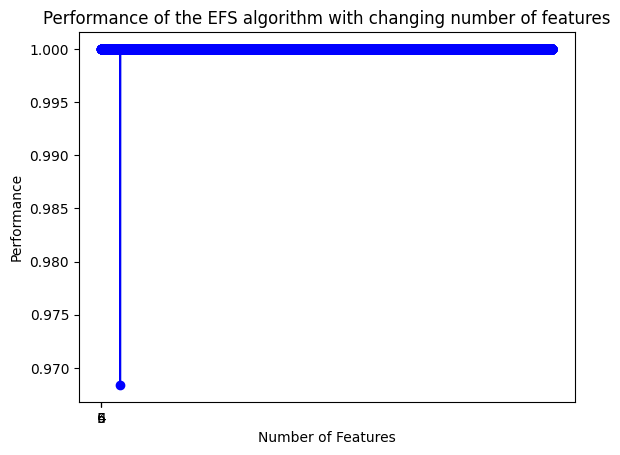

In [99]:
plot_sfs(efs.get_metric_dict(), kind='std_dev')
plt.title('Performance of the EFS algorithm with changing number of features')
plt.show()

In [100]:
print('Best accuracy score: %.2f' % efs.best_score_)
print('Best subset (indices):', efs.best_idx_)
print('Best subset (corresponding names):', efs.best_feature_names_)
selected_features = df1.columns[list(efs.best_idx_)]
print(selected_features)

print(efs.best_score_)

Best accuracy score: 1.00
Best subset (indices): (1, 5, 7, 8, 11, 19)
Best subset (corresponding names): ('sl2l_mean_length', 'ifol_diameter', 'tral_number_of_tracts', 'sl2l_number_of_tracts', 'tral_diameter', 'ecpl_volume')
Index(['sl2l_mean_length', 'ifol_diameter', 'tral_number_of_tracts',
       'sl2l_number_of_tracts', 'tral_diameter', 'ecpl_volume'],
      dtype='object')
1.0000000000000002


#### Regresion logistica
 'ccbd_diameter', 'sl2l_mean_length',  'ecpl_mean_length','ccbd_number_of_tracts'
#### SFS y SBS
 'ccbd_diameter', 'sl2l_mean_length',
 'sl2l_diameter', 'ccbd_mean_length',
 'sl2l_volume', 
 'tral_volume'
#### EFS
  'sl2l_mean_length',
  'ifol_diameter',
  'tral_number_of_tracts',
  'sl2l_number_of_tracts',
  'tral_diameter',
  'ecpl_volume'